In [1]:
import pandas as pd
import numpy as np

In [2]:
batch_size = 32
window_size = int(256) 
validation_size = 128 * batch_size 
test_size = 128 * batch_size 
ma_periods = 2 
ticker = 'eurusd' 
start_date = '2012-01-01' 
seed = 42
model_path = f'{ticker}-{batch_size}-{window_size}-{ma_periods}'
scaler_path = f'{ticker}-{batch_size}-{window_size}-{ma_periods}.bin'
full_time_series_path = f'{ticker}.csv'
train_time_series_path = f'{ticker}-train.csv'
validate_time_series_path = f'{ticker}-validate.csv'
test_time_series_path = f'{ticker}-test.csv'

In [3]:
df_csv = pd.read_csv(full_time_series_path, usecols=['Date','High','Low'], 
    index_col=['Date'], parse_dates=['Date'])
df = df_csv[df_csv.index >= pd.to_datetime(start_date)]
df

,High,Low
Date,,
2022-04-13 21:15:00,1.08930,1.08600
2022-04-13 22:00:00,1.08920,1.08865
2022-04-13 23:00:00,1.08975,1.08890
2022-04-14 00:00:00,1.09000,1.08825
2022-04-14 01:00:00,1.09085,1.08825
...,...,...
2022-04-15 16:00:00,1.08100,1.08060
2022-04-15 17:00:00,1.08115,1.08045
2022-04-15 18:00:00,1.08110,1.08075


In [4]:
df["HLAvg"] = df['High'].add(df['Low']).div(2)
del df['High']
del df['Low']
df['MA'] = df['HLAvg'].rolling(window=ma_periods).mean()
df['Returns'] = np.log(df['MA']/df['MA'].shift(1))
df.head(15)

,HLAvg,MA,Returns
Date,,,
2022-04-13 21:15:00,1.087650,NaN,NaN
2022-04-13 22:00:00,1.088925,1.088287,NaN
2022-04-13 23:00:00,1.089325,1.089125,0.000769
2022-04-14 00:00:00,1.089125,1.089225,0.000092
2022-04-14 01:00:00,1.089550,1.089338,0.000103
2022-04-14 02:00:00,1.090500,1.090025,0.000631
2022-04-14 03:00:00,1.090575,1.090537,0.000470
2022-04-14 04:00:00,1.090825,1.090700,0.000149
2022-04-14 05:00:00,1.091375,1.091100,0.000367


In [5]:
df.dropna(how='any', inplace=True)
df = df[df.shape[0] % batch_size:]
df

,HLAvg,MA,Returns
Date,,,
2022-04-14 13:00:00,1.080325,1.083512,-0.003984
2022-04-14 14:00:00,1.078375,1.079350,-0.003849
2022-04-14 15:00:00,1.079550,1.078962,-0.000359
2022-04-14 16:00:00,1.081300,1.080425,0.001355
2022-04-14 17:00:00,1.081775,1.081538,0.001029
...,...,...,...
2022-04-15 16:00:00,1.080800,1.080800,-0.000035
2022-04-15 17:00:00,1.080800,1.080800,0.000000
2022-04-15 18:00:00,1.080925,1.080863,0.000058


In [6]:
df_train = df[:- validation_size - test_size]
df_validation = df[- validation_size - test_size - window_size:- test_size]
df_test = df[- test_size - window_size:]
print(f'df_train.shape {df_train.shape}, df_validation.shape {df_validation.shape}, df_test.shape {df_test.shape}')

df_train.shape (38880, 3), df_validation.shape (4352, 3), df_test.shape (4352, 3)


In [7]:
df_train.to_csv(train_time_series_path)
df_validation.to_csv(validate_time_series_path)
df_test.to_csv(test_time_series_path)

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential, save_model
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

2022-04-20 08:26:15.903242: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [9]:
def get_train(values, window_size):
    X, y = [], []
    len_values = len(values)
    for i in range(window_size, len_values):
        X.append(values[i-window_size:i])
        y.append(values[i])
    X, y = np.asarray(X), np.asarray(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    print(f"X {X.shape}, y {y.shape}")
    return X, y

def get_val(values, window_size):
    X = []
    len_values = len(values)
    for i in range(window_size, len_values):
        X.append(values[i-window_size:i])
    X = np.asarray(X)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    y = values[-X.shape[0]:]
    print(f"X {X.shape}, y {y.shape}")
    return X, y

In [10]:
epochs = 20
np.random.seed(seed)
tf.random.set_seed(seed)

In [11]:
df = pd.read_csv(train_time_series_path, dayfirst=True, 
    index_col=['Date'], parse_dates=['Date'])
df.head()

,HLAvg,MA,Returns
Date,,,
2022-04-14 13:00:00,1.080325,1.083513,-0.003984
2022-04-14 14:00:00,1.078375,1.079350,-0.003849
2022-04-14 15:00:00,1.079550,1.078962,-0.000359
2022-04-14 16:00:00,1.081300,1.080425,0.001355
2022-04-14 17:00:00,1.081775,1.081538,0.001029


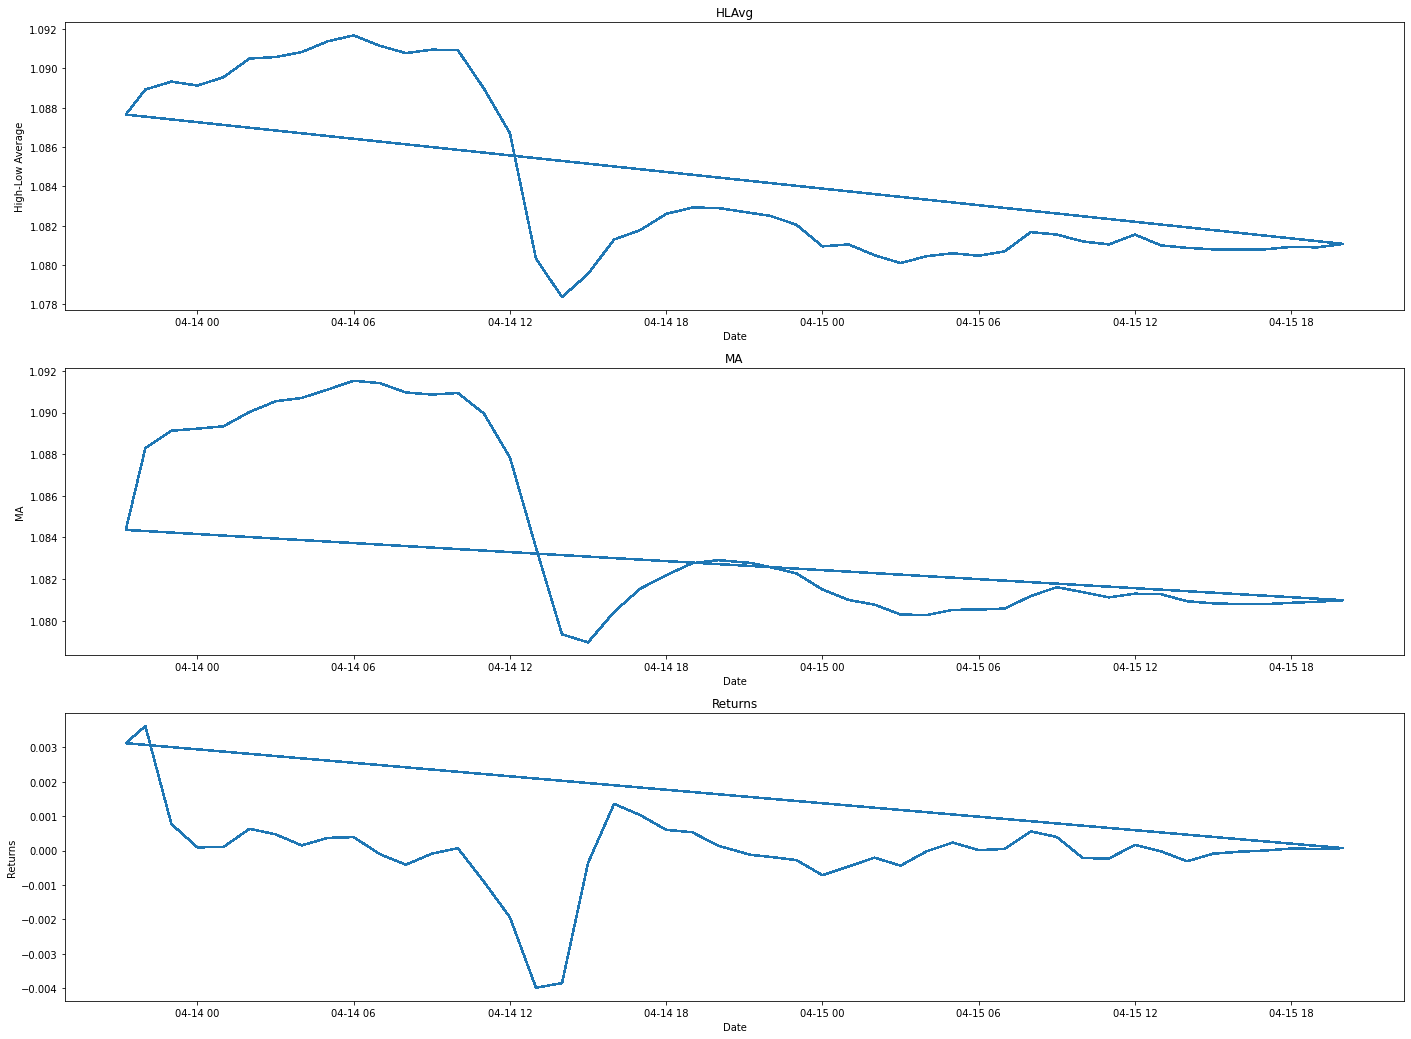

In [12]:
fig = plt.figure(figsize=(24, 18))
ax1, ax2, ax3 = fig.subplots(3)
ax1.set_title('HLAvg')
ax1.set(xlabel='Date', ylabel='High-Low Average')
ax1.plot(df['HLAvg'])
ax2.set_title('MA')
ax2.set(xlabel='Date', ylabel='MA')
ax2.plot(df['MA'])
ax3.set_title('Returns')
ax3.set(xlabel='Date', ylabel='Returns')
ax3.plot(df['Returns'])

In [13]:
scaler = MinMaxScaler()
train_values = scaler.fit_transform(df[['Returns']].values)

In [ ]:
fig = plt.figure(figsize=(24, 8))
ax1 = fig.subplots(1)
ax1.set_title('Returns MinMax Scaled')
ax1.set(xlabel='Sample', ylabel='Scaled Returns')
ax1.plot(train_values)

In [15]:
X, y = get_train(train_values, window_size)

X (38624, 256, 1), y (38624, 1)


In [16]:
df_val = pd.read_csv(validate_time_series_path, dayfirst = True, usecols=['Date','Returns'],
    index_col=['Date'], parse_dates=['Date'])
df_val['Scaled'] = scaler.transform(df_val[['Returns']].values)
X_val, y_val = get_val(df_val['Scaled'].values, window_size)

X (4096, 256, 1), y (4096,)


In [17]:
model = Sequential()
model.add(LSTM(76, input_shape=(X.shape[1], 1), return_sequences = False))
model.add(Dropout(0.2))
model.add(Dense(1))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss="mse", optimizer=optimizer)

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 76)                23712     
_________________________________________________________________
dropout (Dropout)            (None, 76)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 77        
Total params: 23,789
Trainable params: 23,789
Non-trainable params: 0
_________________________________________________________________
None


2022-04-20 08:26:17.520814: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-04-20 08:26:17.521426: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-04-20 08:26:17.544963: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-20 08:26:17.545303: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:0a:00.0 name: NVIDIA GeForce RTX 2060 SUPER computeCapability: 7.5
coreClock: 1.65GHz coreCount: 34 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 417.29GiB/s
2022-04-20 08:26:17.545328: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-04-20 08:26:17.547116: I tensorflow/stream_executor/platfo

In [18]:
history = model.fit(X, y, validation_data=(X_val, y_val), epochs = epochs, batch_size = batch_size, shuffle=False, verbose = 1)

2022-04-20 08:26:17.686838: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-04-20 08:26:17.706976: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3793065000 Hz


Epoch 1/20
1207/1207 [==============================] - 40s 33ms/step - loss: 0.0508 - val_loss: 0.0218
Epoch 2/20
1207/1207 [==============================] - 39s 33ms/step - loss: 0.0221 - val_loss: 0.0179
Epoch 3/20
1207/1207 [==============================] - 40s 33ms/step - loss: 0.0188 - val_loss: 0.0151
Epoch 4/20
1207/1207 [==============================] - 39s 33ms/step - loss: 0.0165 - val_loss: 0.0137
Epoch 5/20
1207/1207 [==============================] - 39s 32ms/step - loss: 0.0153 - val_loss: 0.0119
Epoch 6/20
1207/1207 [==============================] - 39s 32ms/step - loss: 0.0132 - val_loss: 0.0110
Epoch 7/20
1207/1207 [==============================] - 39s 32ms/step - loss: 0.0122 - val_loss: 0.0103
Epoch 8/20
1207/1207 [==============================] - 39s 32ms/step - loss: 0.0116 - val_loss: 0.0099
Epoch 9/20
1207/1207 [==============================] - 39s 32ms/step - loss: 0.0110 - val_loss: 0.0090
Epoch 10/20
1207/1207 [==============================] - 39s 32m

In [19]:
save_model(model, model_path)
joblib.dump(scaler, scaler_path) 

2022-04-20 08:39:22.123324: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: eurusd-32-256-2/assets


INFO:tensorflow:Assets written to: eurusd-32-256-2/assets


['eurusd-32-256-2.bin']

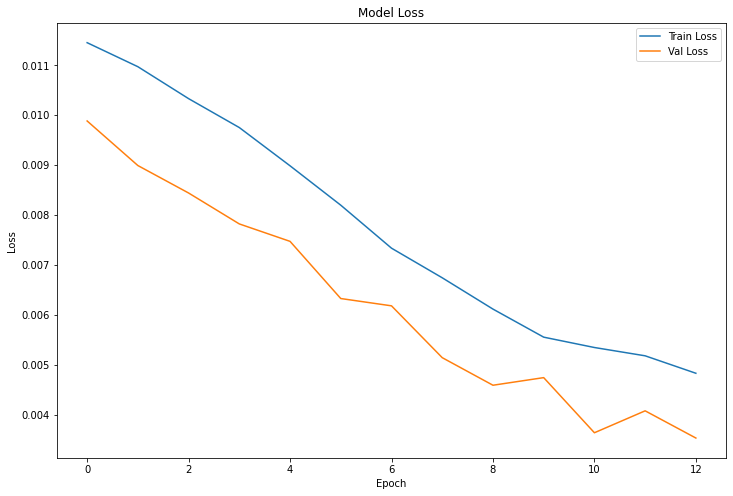

In [20]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.subplots(1)
ax1.set_title('Model Loss')
ax1.set(xlabel='Epoch', ylabel='Loss')
ax1.plot(history.history['loss'][7:], label='Train Loss')
ax1.plot(history.history['val_loss'][7:], label='Val Loss')
ax1.legend()